In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import lightkurve as lk



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

3573.4833984375


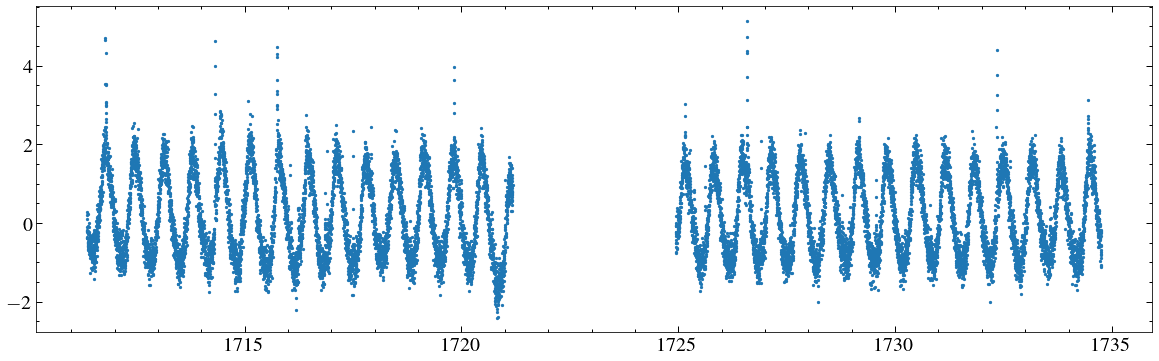

ValueError: Input values did not match the format class jd:
TypeError: Input values for jd class must be finite doubles

<Figure size 1440x432 with 0 Axes>

In [4]:
eg_uma_fits= ['/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2019226182529-s0015-0000000416538823-0151-s/tess2019226182529-s0015-0000000416538823-0151-s_lc.fits',
'/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2020049080258-s0022-0000000416538823-0174-s/tess2020049080258-s0022-0000000416538823-0174-s_lc.fits']


fitter = fitting.LevMarLSQFitter()




for tessfits in eg_uma_fits:
    hdul = fits.open(tessfits)
    #data = fits.getdata(tessfits, 1)
    data = hdul[1].data
    hdr = hdul[0].header
 #   print(hdr['RA_OBJ'], hdr['DEC_OBJ'])
    hdul.close()
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    t, f, e = t[q==0], f[q==0], e[q==0]
  #  fit = np.polyval((np.polyfit(t,f,1)), t)
    #f = (f/fit)-1
    #e = (e/fit)-1
    #med = np.median(f)
    #print(med)
   # f = (f/med)-1
   # print(f)
   # e = (e/med)
    plt.figure(figsize=(20, 6))
    lc = lk.LightCurve(time=t*u.d, flux=f, flux_err=e).remove_outliers(sigma=5)#.flatten(window_length=1001).remove_nans()
    lc = lc.remove_nans()
    med = np.median(lc.flux)
    print(med)
    lc.flux /= med
    lc.flux -= 1
    lc.flux  *= 100
    lc.flux_err *= 100
    plt.scatter(lc.time.value,lc.flux, s=5)
    #plt.axhline(med*100, c='C1')
    plt.show()
    
    #plt.subplot(131)

In [ ]:
eg_uma_fits= ['/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2019226182529-s0015-0000000416538823-0151-s/tess2019226182529-s0015-0000000416538823-0151-s_lc.fits',
'/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2020049080258-s0022-0000000416538823-0174-s/tess2020049080258-s0022-0000000416538823-0174-s_lc.fits']


fitter = fitting.LevMarLSQFitter()




for tessfits in eg_uma_fits:
    hdul = fits.open(tessfits)
    #data = fits.getdata(tessfits, 1)
    data = hdul[1].data
    hdr = hdul[0].header
    print(hdr['RA_OBJ'], hdr['DEC_OBJ'])
    hdul.close()
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    t, f, e = t[q==0], f[q==0], e[q==0]
  #  fit = np.polyval((np.polyfit(t,f,1)), t)
    #f = (f/fit)-1
    #e = (e/fit)-1
 #   med = np.median(f)
   # print(med)
  #  f = (f/med)-1
  #  print(f)
  #  e = (e/med)
    plt.figure(figsize=(20, 6))
    lc = lk.LightCurve(time=t, flux=f, flux_err=e).remove_outliers(sigma=5).remove_nans()#.flatten(window_length=1001).remove_nans()
    med = np.median(lc.flux)
    print(med)
    lc.flux /= med
    lc.flux_err /= med
    lc.flux -= 1
   # lc.flux -= 1
    lc.flux  *= 100
    lc.flux_err *= 100
    
    plt.subplot(131)

    
    mask = (lc.flux <3) #flares 
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=25*u.day)
    plt.plot(pg.period, pg.power)
    plt.xscale('log')
    
    plt.subplot(132)
    plt.scatter(lc.time,lc.flux, s=5)
    

    
    sin_mod =  (models.Sine1D(amplitude=pg.max_power, frequency= pg.frequency_at_max_power.value) 
                + models.Sine1D(amplitude=pg.max_power, frequency= (pg.frequency_at_max_power.value)*2))
    sin_fit = fitter(sin_mod, lc.time[mask], lc.flux[mask], weights = 1/lc.flux_err[mask], maxiter=1000)
    sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    timefit = np.linspace(lc.time[0], lc.time[-1], 2000)
    plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 
    print('Period =', (1/sin_fit[0].frequency.value)*24, (sin_fit_e[1]/(sin_fit[0].frequency.value**2))*24, 'h')
    print('Period2 =', (1/sin_fit[1].frequency.value)*24, (sin_fit_e[4]/(sin_fit[1].frequency.value**2))*24, 'h')
    print('Amplitude =', sin_fit[0].amplitude.value, sin_fit_e[0])
    print('Amplitude2 =', sin_fit[1].amplitude.value, sin_fit_e[3])

    

    print(pg.period_at_max_power.to(u.hour))
    plt.subplot(133)
    lcf = lc[mask].fold(2/sin_fit[0].frequency).bin(50)
    mf = lk.LightCurve(time=timefit, flux=sin_fit(timefit)).fold(2/sin_fit[0].frequency)
    plt.scatter(lcf.time, lcf.flux, s=5)
    plt.plot(mf.time, mf.flux, c='C1')
    

In [ ]:
3150 *0.015

In [ ]:
eg_uma_fits= ['/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2019226182529-s0015-0000000416538823-0151-s/tess2019226182529-s0015-0000000416538823-0151-s_lc.fits',
'/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2020049080258-s0022-0000000416538823-0174-s/tess2020049080258-s0022-0000000416538823-0174-s_lc.fits']


fitter = fitting.LevMarLSQFitter()




for tessfits in eg_uma_fits:
    hdul = fits.open(tessfits)
    #data = fits.getdata(tessfits, 1)
    data = hdul[1].data
    hdr = hdul[0].header
    print(hdr['RA_OBJ'], hdr['DEC_OBJ'])
    hdul.close()
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    plt.step(t, q, where='mid')
    plt.ylim(500, 520)
    #plt.scatter(t, f, s=5)
    #t, f, e = t[q==0], f[q==0], e[q==0]
    #plt.scatter(t, f, s=5)
    
    plt.show()
    
 

In [ ]:
.66765930*24

In [ ]:
newtime = np.arange(2449800, 2449801.5, 0.01)

plt.plot(newtime, sin_fit(newtime), c='C1', lw=2) 
plt.axvline(2449800.79131)